## Generate Report and Interpretation
---
* Performance report on deciles
* PDP
* SHAP

In [1]:
import sys, os
import pandas as pd
import numpy as np
import pickle as pkl
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
import rdsutils.plot as rdsplot
import utils

In [2]:
modeling_df = pd.read_parquet('../../artifacts/final/modeling_df_w_preds.parquet')
test_df = pd.read_parquet('../../artifacts/final/test_df_w_preds.parquet')
modeling_df.shape, test_df.shape

((112599, 241), (152951, 241))

In [3]:
seed = 12345
target_col = 'ach_target'
indeterminate = 'indeterminate_60d'
model_output = 'probability'

modeling_df = utils.preprocess(modeling_df)
test_df = utils.preprocess(test_df)

modeling_df['pred'] = modeling_df['ach_pred_cleaned']
test_df['pred'] = test_df['ach_pred_cleaned']

# modeling_df['pred'] = modeling_df['ach_pred_constrainted']
# test_df['pred'] = test_df['ach_pred_constrainted']


In [4]:
display(modeling_df[target_col].value_counts(), 
        test_df[target_col].value_counts())

False    108825
True       3774
Name: ach_target, dtype: int64

False    145410
True       7541
Name: ach_target, dtype: int64

### Performance
---

In [5]:
model_preds = ['pred']
OOS_preds = ['deposit_v1_pred', 'customer_pred'] + model_preds
OOT_preds = ['deposit_v1_pred', 'customer_pred'] + model_preds

In [6]:
import scikitplot as skplt
import matplotlib.pyplot as plt

plt.style.use('seaborn')

def get_binary_metrics(y_true, y_pred):
    from sklearn.metrics import roc_auc_score, average_precision_score
    from scikitplot.helpers import binary_ks_curve
    
    auc = round(roc_auc_score(y_true=y_true,
                              y_score=y_pred)*100, 2)
    ap = round(average_precision_score(y_true=y_true,
                                       y_score=y_pred)*100, 2)
    _, _, _, ks, _, _ = binary_ks_curve(y_true=y_true, y_probas=y_pred)
    ks = round(ks*100, 2) 
    
    metrics = {'auc': auc,
               'ap': ap}

    return metrics


def get_pred_reports(df, target_col, pred_cols):
    import pandas as pd
    result = {}
    for col in pred_cols:
        metrics = get_binary_metrics(df[target_col], df[col])
        result[col] = metrics
    return pd.DataFrame(result).T

In [7]:
# OOS results
metrics = get_pred_reports(modeling_df, target_col, OOS_preds)
metrics

,auc,ap
deposit_v1_pred,85.06,27.62
customer_pred,89.19,51.03
pred,92.77,66.28


In [8]:
# OOT results
metrics = get_pred_reports(test_df, target_col, OOT_preds)
metrics

,auc,ap
deposit_v1_pred,83.61,29.14
customer_pred,88.94,49.57
pred,93.19,67.07


In [8]:
# Only the official pred; mcd_pred = mcd_more_features_no_corr_0.6_pred	
modeling_df['ach_pred'] = modeling_df['pred']
metrics_oos = get_pred_reports(modeling_df, target_col,
                           ['deposit_v1_pred',
                            'customer_pred',
                            'pred'])
display('OOS')
display(metrics_oos)

metrics_oot = get_pred_reports(test_df, target_col,
                           ['deposit_v1_pred',
                            'customer_pred',
                            'pred'])
display('OOT')
display(metrics_oot)

'OOS'

,auc,ap
deposit_v1_pred,85.06,27.62
customer_pred,89.19,51.03
pred,92.77,66.28


'OOT'

,auc,ap
deposit_v1_pred,83.61,29.14
customer_pred,88.94,49.57
pred,93.19,67.07


In [12]:
print("ACH pred by month")
df_ = test_df[test_df["transaction_datetime"].between(pd.to_datetime('2020-08-01'),
                                                      pd.to_datetime('2020-08-31'))]
print(df_.shape)

metrics_oot = get_pred_reports(df_, target_col,
                           ['deposit_v1_pred',
                            'customer_pred',
                            'pred'])
display(metrics_oot)

df_ = test_df[test_df["transaction_datetime"].between(pd.to_datetime('2020-09-01'),
                                                      pd.to_datetime('2020-09-30'))]
print(df_.shape)

metrics_oot = get_pred_reports(df_, target_col,
                           ['deposit_v1_pred',
                            'customer_pred',
                            'pred'])
display(metrics_oot)

df_ = test_df[test_df["transaction_datetime"].between(pd.to_datetime('2020-10-01'),
                                                      pd.to_datetime('2020-10-31'))]
print(df_.shape)

metrics_oot = get_pred_reports(df_, target_col,
                           ['deposit_v1_pred',
                            'customer_pred',
                            'pred'])
display(metrics_oot)

ACH pred by month
(51242, 241)


,auc,ap
deposit_v1_pred,84.33,30.98
customer_pred,88.71,51.73
pred,93.49,70.19


(45611, 241)


,auc,ap
deposit_v1_pred,82.96,28.19
customer_pred,89.06,47.21
pred,92.90,64.71


(49968, 241)


,auc,ap
deposit_v1_pred,82.92,27.88
customer_pred,88.88,49.79
pred,93.17,66.74


### Plots
---

In [10]:
def plot_pr_curve_mult(y_test, y_scores, title=None, 
                       colors=['b'], figsize=None,
                       ax=None, fig=None, **kwargs):
    """Plot multiple precision-recall curves on the same canvas.
    
    Parameters
    ----------
    y_test : pd.Series, np.ndarray - shape [n]
        Targets.
    y_scores: [(y_score, label), ...]
        list of tuples with y_score and corresponding label
        y_score - pd.Series
        label - str - label to show in legend
    title: str
        title for the plot
    colors: list(str)
        list of colors for the y_scores respectively
    figsize: tuple(int)
        figure size for plt
    
        
    Returns
    -------
    fig:
        matplotlib figure
    ax:
        matplotlib axis
    """
    assert(len(y_scores) == len(colors))
    from sklearn.metrics import average_precision_score
    from sklearn.metrics import precision_recall_curve
    import matplotlib.pyplot as plt
    
    aps = []
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
            
    for i in range(len(y_scores)):
        y_score, label = y_scores[i]
        
        average_precision = average_precision_score(y_test, y_score)
        aps.append(average_precision)
        precision, recall, _ = precision_recall_curve(y_test, y_score, **kwargs)

        ax.step(recall, precision, color=colors[i], alpha=0.2,
                 where='post', label=label)
        ax.fill_between(recall, precision, alpha=0.2, color=colors[i])
    
    ax.legend()

    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_ylim([0.0, 1.05])
    ax.set_xlim([0.0, 1.0])
    ax.set_title(title)
    
    return fig, ax

def plot_auc_curve_mult(y_test, y_scores, title, 
                        colors=['b'], figsize=None,
                        ax=None, fig=None, **kwargs):
    """Plot multiple AUC-ROC curves on the same canvas.
    
    Parameters
    ----------
    y_test : pd.Series, np.ndarray - shape [n]
        Targets.
    y_scores: [(y_score, label), ...]
        list of tuples with y_score and corresponding label
        y_score - pd.Series
        label - str - label to show in legend
    title: str
        title for the plot
    colors: list(str)
        list of colors for the y_scores respectively
    figsize: tuple(int)
        figure size for plt
    
        
    Returns
    -------
    fig:
        matplotlib figure
    ax:
        matplotlib axis
    """
    assert(len(y_scores) == len(colors))
    from sklearn.metrics import roc_curve, roc_auc_score
    import matplotlib.pyplot as plt
    
    aucs = []
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
        
    for i in range(len(y_scores)):
        y_score, label = y_scores[i]
        
        aucroc = roc_auc_score(y_test, y_score)
        aucs.append(aucroc)
        fpr, tpr, _ = roc_curve(y_test, y_score)

        ax.step(fpr, tpr, color=colors[i], alpha=0.2,
                 where='post', label=label)
        ax.fill_between(fpr, tpr, alpha=0.2, color=colors[i])
        
    
    plt.legend()

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    ax.set_ylim([0.0, 1.05])
    ax.set_xlim([0.0, 1.0])
    ax.set_title(title)
    
    return fig, ax

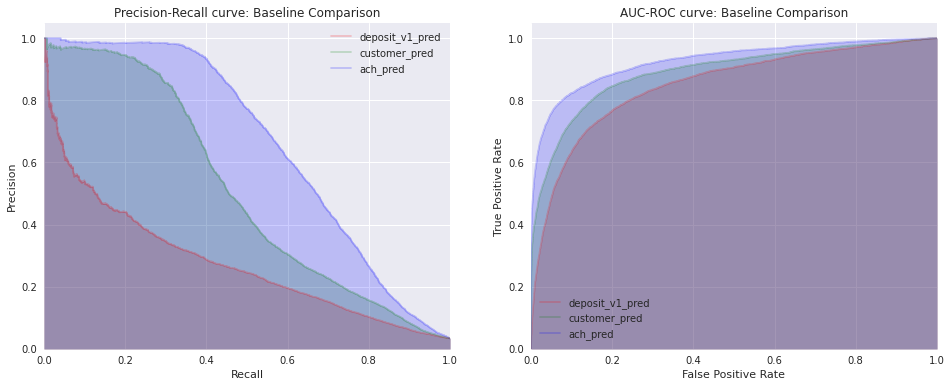

In [18]:
# OOS best predictions
fig, axs = plt.subplots(1, 2, figsize=(16,6))

preds = [(modeling_df['deposit_v1_pred'], 'deposit_v1_pred'), 
         (modeling_df['customer_pred'], 'customer_pred'),
         (modeling_df['pred'], 'ach_pred')
        ]

title = 'Precision-Recall curve: Baseline Comparison'
plot_pr_curve_mult(modeling_df[target_col], preds,
                   title=title, colors = ['r', 'g', 'b'], 
                   ax=axs[0], fig=fig) 

title = 'AUC-ROC curve: Baseline Comparison'
plot_auc_curve_mult(modeling_df[target_col], preds,
                   title=title, colors = ['r', 'g', 'b'], 
                   ax=axs[1], fig=fig)
plt.show()

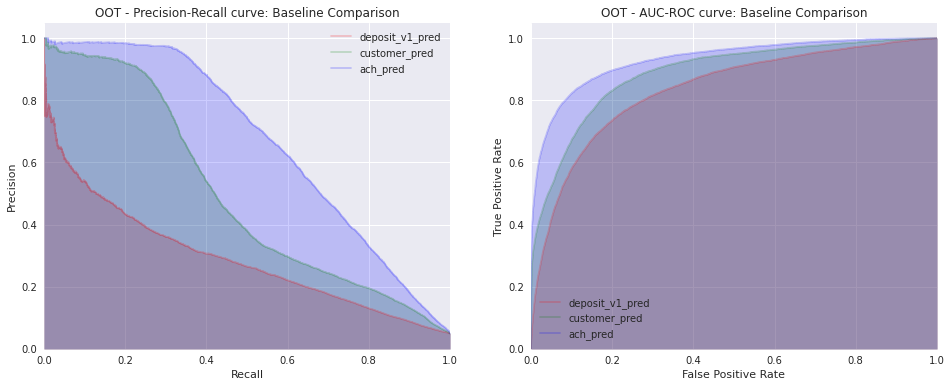

In [19]:
# OOT best predictions
fig, axs = plt.subplots(1, 2, figsize=(16,6))

preds = [(test_df['deposit_v1_pred'], 'deposit_v1_pred'), 
         (test_df['customer_pred'], 'customer_pred'),
         (test_df['pred'], 'ach_pred')
        ]

title = 'OOT - Precision-Recall curve: Baseline Comparison'
plot_pr_curve_mult(test_df[target_col], preds,
                   title=title, colors = ['r', 'g', 'b'], 
                   ax=axs[0], fig=fig) 

title = 'OOT - AUC-ROC curve: Baseline Comparison'
plot_auc_curve_mult(test_df[target_col], preds,
                   title=title, colors = ['r', 'g', 'b'], 
                   ax=axs[1], fig=fig)
plt.show()

### Feature Importance
---

In [13]:
plt.style.use('seaborn-poster')

In [14]:
with open('../../models/ach-model.pkl', 'rb') as f:
    model = pkl.load(f)
    
os.makedirs('../../artifacts/final/plots', exist_ok=True)

In [15]:
len(model.feature_name_)

26

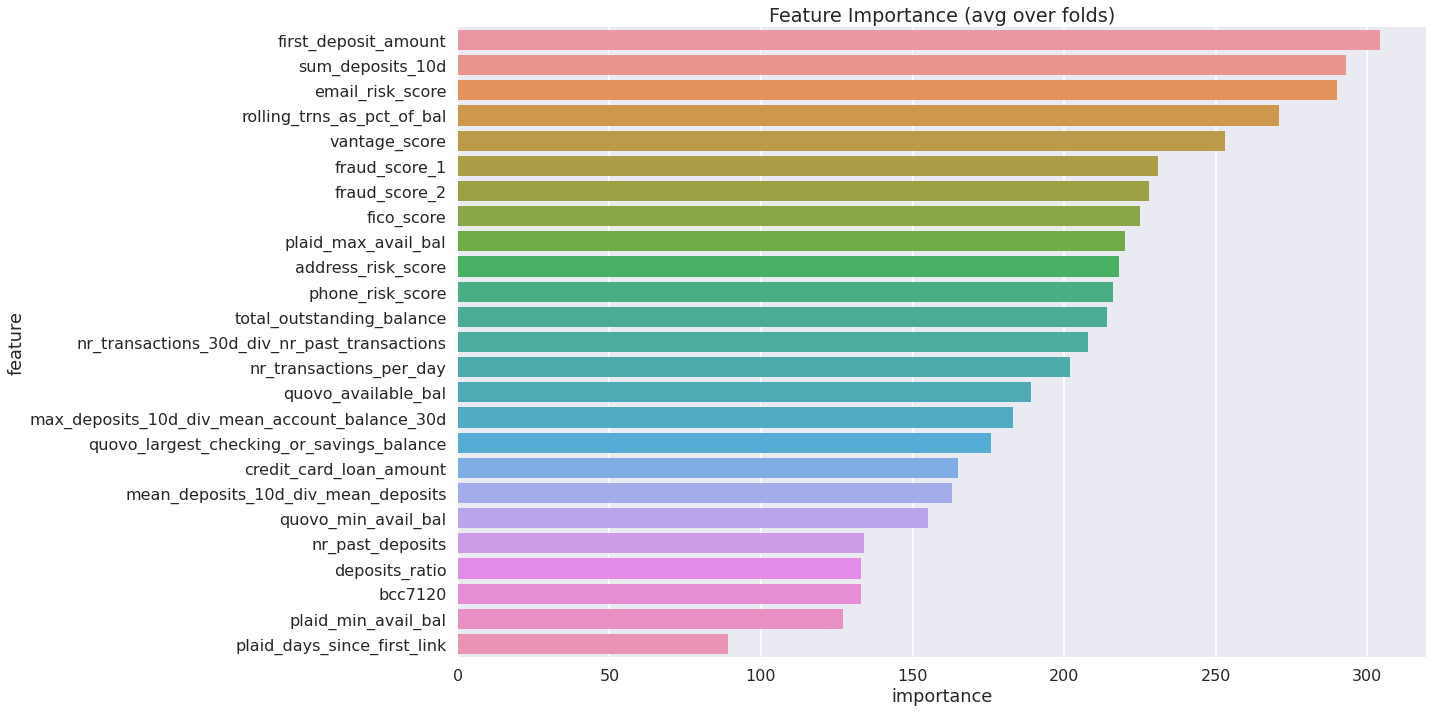

In [16]:
fig, axs = rdsplot.display_feature_importance(model.feature_name_,
                                   model.feature_importances_, 
                                   max_n_features=-1, figsize=(20,10))                                  
plt.savefig('../../artifacts/final/plots/feature_importance_full.png')

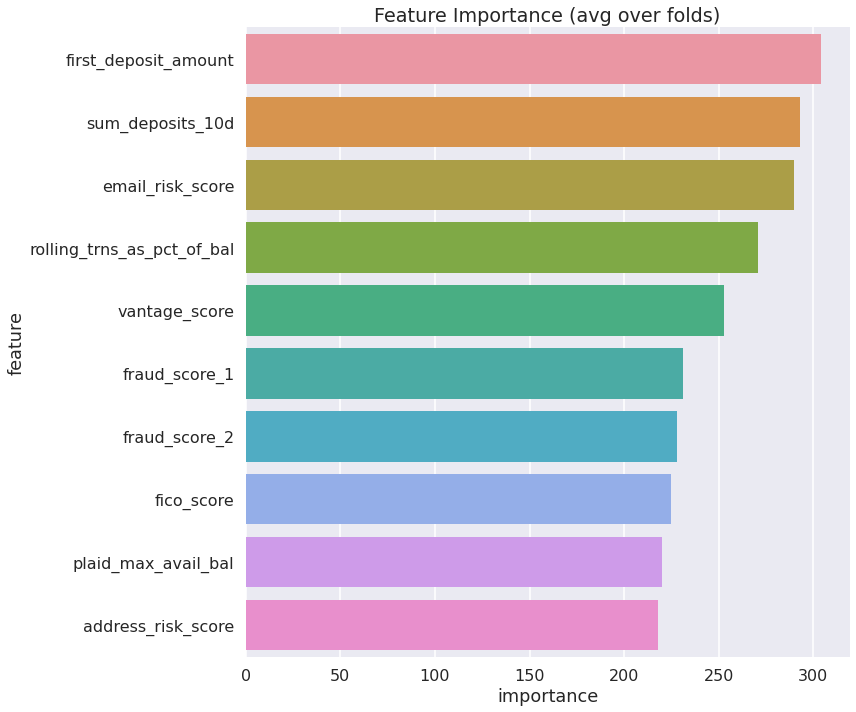

In [17]:
fig, axs = rdsplot.display_feature_importance(model.feature_name_,
                                   model.feature_importances_, 
                                   max_n_features=10, figsize=(12,10))                                  
plt.savefig('../../artifacts/final/plots/feature_importance_full.png')

### Fico
---

In [20]:
# invalid fico
index = modeling_df.reset_index()[['business_account_number', 'index']].groupby('business_account_number')['index'].apply(lambda df: df.iloc[-1]).values
f_df = modeling_df.loc[index, :]
(f_df.fico_score.isna() | (f_df.fico_score > 850)).value_counts(normalize=True)

False    0.857176
True     0.142824
Name: fico_score, dtype: float64

In [21]:
modeling_df_w_fico = modeling_df[(~modeling_df.fico_score.isna()) 
                        & (modeling_df.fico_score <= 850)]
modeling_df_w_fico['fico_pred'] = -modeling_df_w_fico.fico_score

test_df_w_fico = test_df[(~test_df.fico_score.isna()) 
                        & (test_df.fico_score <= 850)]
test_df_w_fico['fico_pred'] = -test_df_w_fico.fico_score


/home/ec2-user/anaconda3/envs/ml_basic_py37/lib/python3.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/ec2-user/anaconda3/envs/ml_basic_py37/lib/python3.7/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [22]:
metrics = get_pred_reports(modeling_df_w_fico, target_col,
                           ['deposit_v1_pred',
                            'pred'])
display('OOS')
display(metrics)

metrics = get_pred_reports(test_df_w_fico, target_col,
                           ['fico_pred',
                            'deposit_v1_pred',
                            'customer_pred',
                            'pred'])
display('OOT')
display(metrics)

'OOS'

,auc,ap
deposit_v1_pred,83.74,23.36
pred,92.05,62.85


'OOT'

,auc,ap
fico_pred,84.68,20.45
deposit_v1_pred,82.65,26.37
customer_pred,88.30,47.34
pred,92.76,65.23


In [23]:
plt.style.use('seaborn')

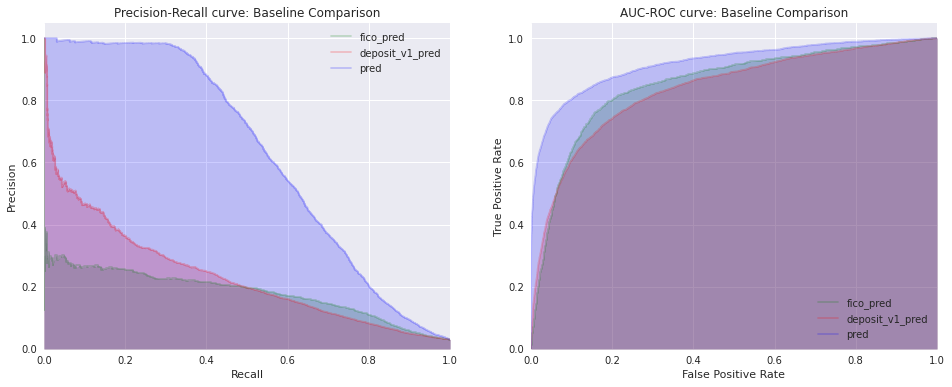

In [24]:
# OOS best predictions

fig, axs = plt.subplots(1, 2, figsize=(16,6))

preds = [(modeling_df_w_fico['fico_pred'], 'fico_pred'),
         (modeling_df_w_fico['deposit_v1_pred'], 'deposit_v1_pred'),
#          (modeling_df['refitted_customer_pred'], 'refitted_customer_pred'),
         (modeling_df_w_fico['pred'], 'pred')
        ]

title = 'Precision-Recall curve: Baseline Comparison'
plot_pr_curve_mult(modeling_df_w_fico[target_col], preds,
                   title=title, colors = ['g', 'r', 'b'], 
                   ax=axs[0], fig=fig) 

title = 'AUC-ROC curve: Baseline Comparison'
plot_auc_curve_mult(modeling_df_w_fico[target_col], preds,
                   title=title, colors = ['g', 'r', 'b'], 
                   ax=axs[1], fig=fig)
plt.show()

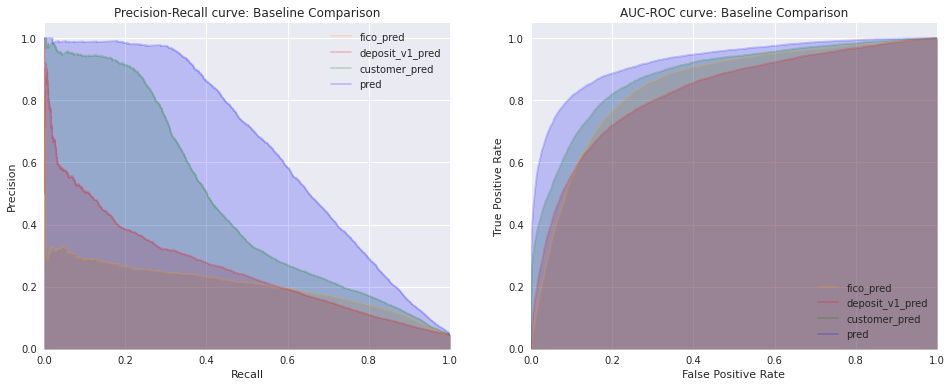

In [25]:
# OOT best predictions

fig, axs = plt.subplots(1, 2, figsize=(16,6))

preds = [(test_df_w_fico['fico_pred'], 'fico_pred'),
         (test_df_w_fico['deposit_v1_pred'], 'deposit_v1_pred'),
         (test_df_w_fico['customer_pred'], 'customer_pred'),
         (test_df_w_fico['pred'], 'pred')
        ]

title = 'Precision-Recall curve: Baseline Comparison'
plot_pr_curve_mult(test_df_w_fico[target_col], preds,
                   title=title, colors = ['orange', 'r', 'g', 'b'], 
                   ax=axs[0], fig=fig) 

title = 'AUC-ROC curve: Baseline Comparison'
plot_auc_curve_mult(test_df_w_fico[target_col], preds,
                   title=title, colors = ['orange', 'r', 'g', 'b'], 
                   ax=axs[1], fig=fig)
plt.show()

### SHAP
---

In [33]:
sample = modeling_df[model.feature_name_].sample(10000, random_state=seed)
sample.shape, modeling_df.shape

((10000, 26), (112599, 243))

In [34]:
import shap

shap.initjs()
# explainer = shap.TreeExplainer(model, data=sample, model_output=model_output)  ## probability
# shap_values = explainer.shap_values(modeling_df[model.feature_name_])
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(modeling_df[model.feature_name_])[1]

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


In [35]:
import math
import matplotlib.pyplot as plt
from tqdm import tqdm

def get_shap_dependence(df, shap_values, features, ncols=6, figsize=None, **kwargs):
    """
    Build the partial dependence plot for a set of models and features.
    """
    nrows = math.ceil(len(features) / ncols)

    if figsize is None:
        figsize = (ncols * 6, nrows * 6)

    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    for feature, ax in zip(features, axs.flatten()):
        shap.dependence_plot(feature, shap_values, df, 
                             ax=ax, show=False, **kwargs)
        rlim = df[feature].quantile(0.98)
        llim = df[feature].quantile(0.02) - ((rlim - df[feature].quantile(0.02)) / 12)
            
        if rlim < np.inf and llim > -np.inf:
            ax.set_xlim(left=llim, right=rlim)
        
    return fig

In [36]:
fimp = sorted(zip(model.feature_importances_, model.feature_name_), reverse=True)
features_by_imp = list(list(zip(*fimp))[1])

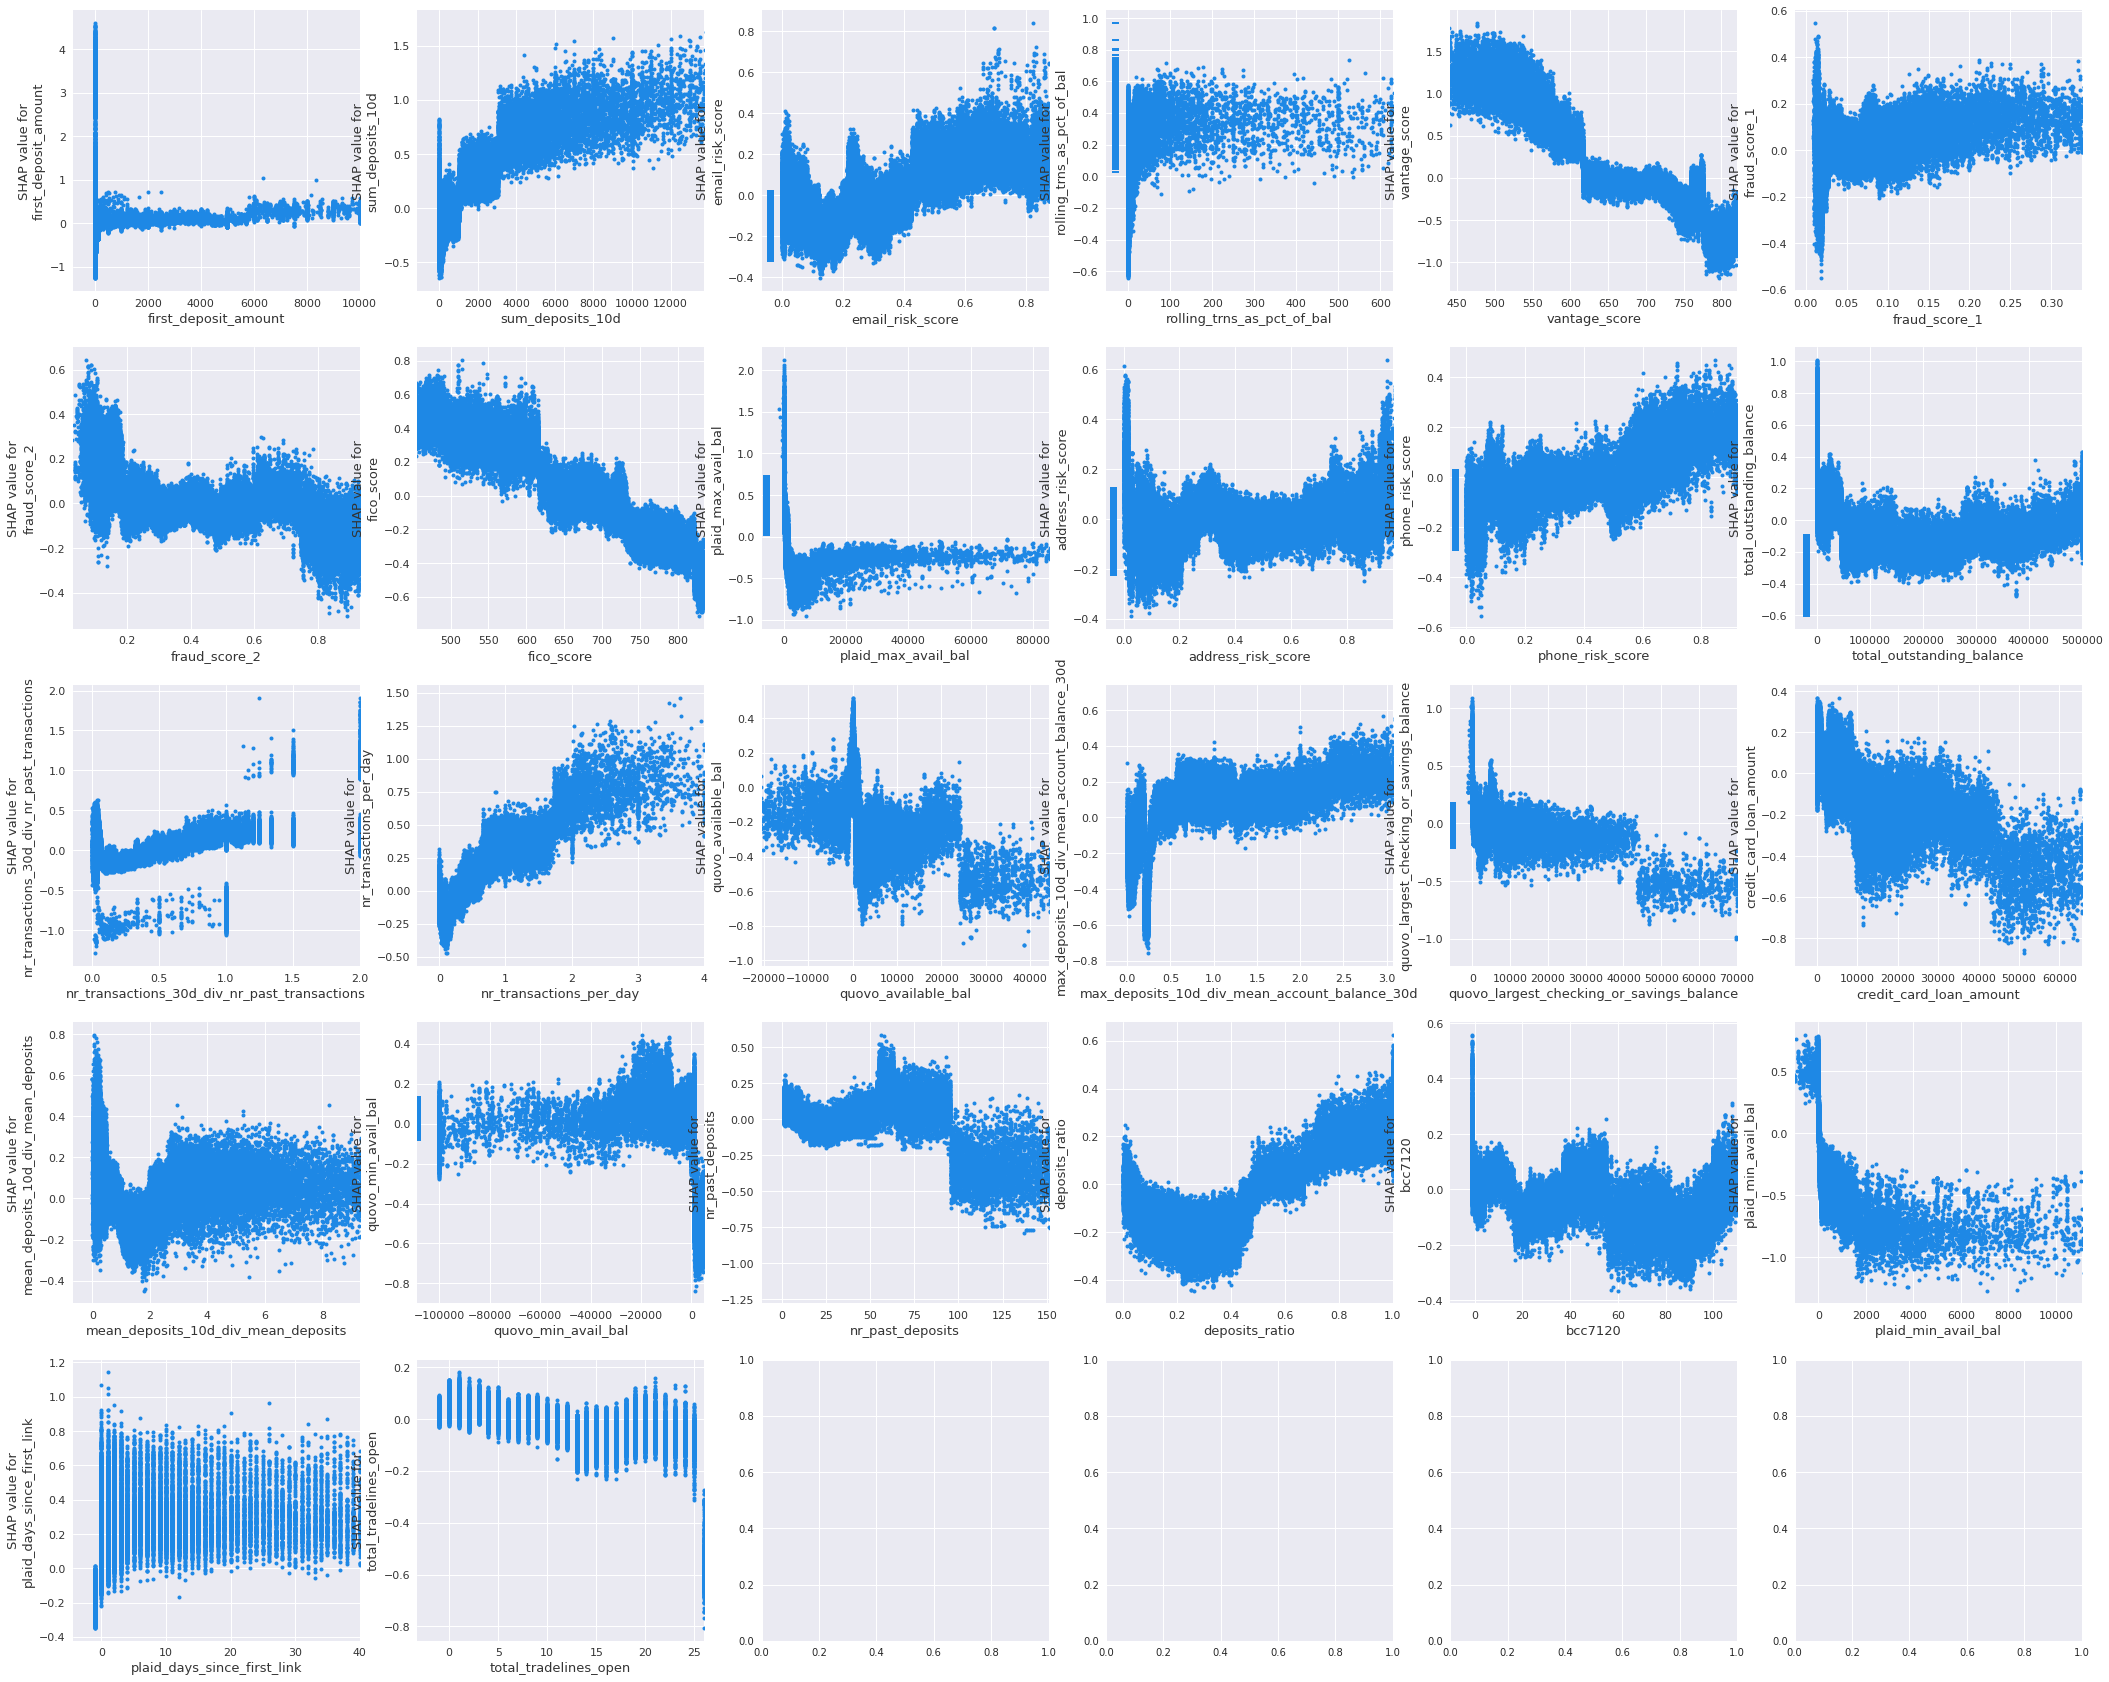

In [37]:
# full
fig = get_shap_dependence(modeling_df[model.feature_name_], 
                          shap_values, features_by_imp, interaction_index=None)
fig.savefig('../../artifacts/final/plots/shap_values_ach_final.png')

# full
# fig = get_shap_dependence(modeling_df[model.feature_name_], 
#                           shap_values[1], features_by_imp, interaction_index=None)
# fig.savefig('../../artifacts/final/plots/shap_values_ach_final_prob.png')

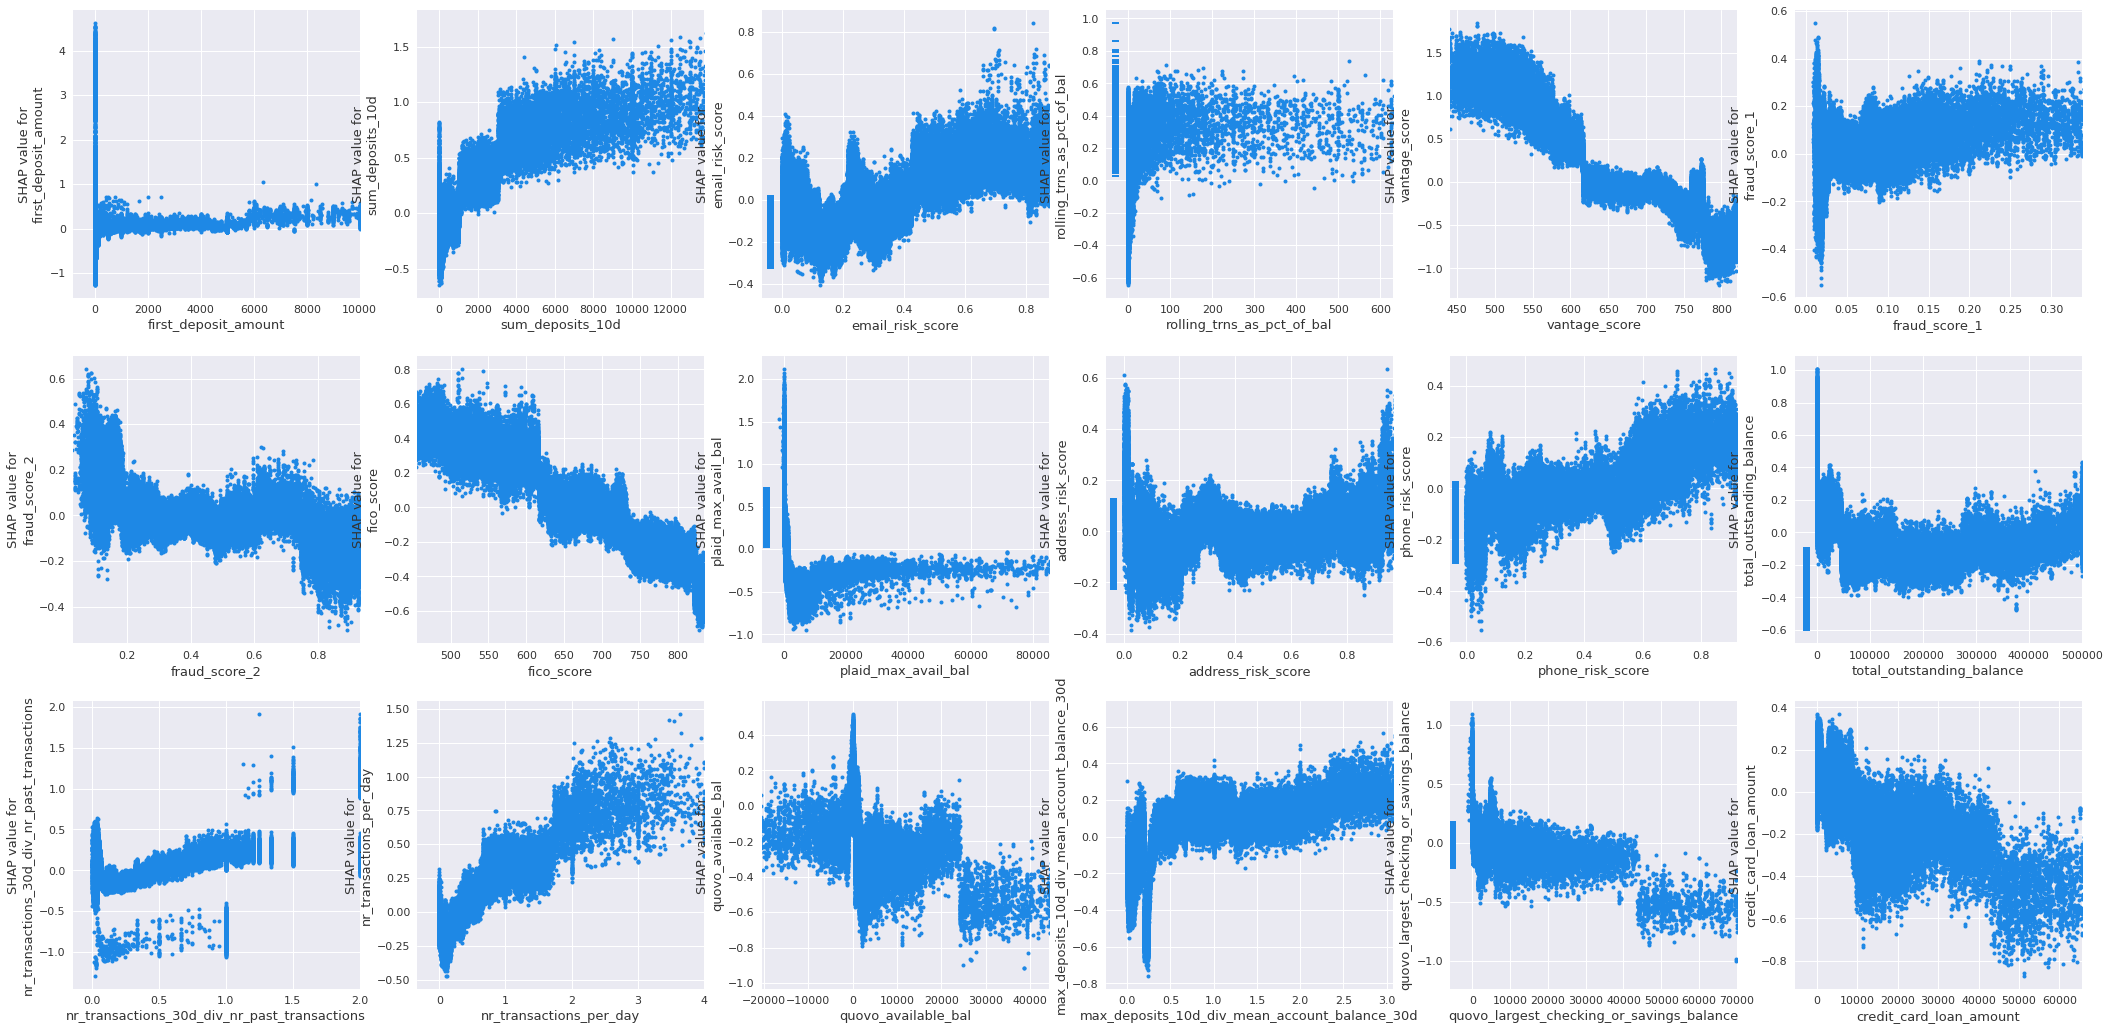

In [38]:
# top 18
fig = get_shap_dependence(modeling_df[model.feature_name_], 
                          shap_values, features_by_imp[:18], interaction_index=None)
fig.savefig('../../artifacts/final/plots/shap_values_ach_top18_final.png')

# # top 18
# fig = get_shap_dependence(modeling_df[model.feature_name_], 
#                           shap_values[1], features_by_imp[:18], interaction_index=None)
# fig.savefig('../../artifacts/final/plots/shap_values_ach_top18_final_prob.png')

In [39]:
# pkl.dump(shap_values, open('../../models/ach_model_shap_values.pkl', 'wb'))

### PDP
---

In [40]:
import math
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


def partial_dependency(model, df, feature, features, 
                       n_steps=10, sample_size=None):
    """
    Calculate partial dependency of a feature given a model.
    """
    if sample_size:
        d = df.sample(sample_size).copy()
    else:
        d = df.copy()
    grid = np.linspace(df[feature].quantile(0.001),
                       df[feature].quantile(.995),
                       n_steps)
    preds = []

    for x in grid:
        d[feature] = x
        y = np.average(model.predict(d[features]))
        preds.append([x, y])
    return np.array(preds).T[0], np.array(preds).T[1]


def partial_dependency_plot_cv(ax, models, df, 
                               feature, features, n_steps=10, 
                               sample_size=None, ylab=None):
    """
    Return partial dependence plot for a feature on a set of models.
    """
    d = df.copy()

    partial_dependencies = []
    y_mean = np.array([0] * n_steps)
    x_mean = []

    y_min = np.inf
    y_max = -np.inf
    d[d[feature] == np.inf] = np.nan #edge case

    for model in models:
        x, y = partial_dependency(model, d, feature, 
                                  features, n_steps=n_steps, 
                                  sample_size=sample_size)
        
        y_min = min(y_min, min(y))
        y_max = max(y_max, max(y))
        
        y_mean = y_mean + (y / len(models))
        x_mean = x
        partial_dependencies.append([x, y])

        for x, y in partial_dependencies:
            ax.plot(x, y, '-', linewidth=1.4, alpha=0.6)

    ax.plot(x_mean, y_mean, '-', color = 'red', linewidth = 2.5)
    ax.set_xlim(d[feature].quantile(0.001), d[feature].quantile(0.995))
    ax.set_ylim(y_min*0.99, y_max*1.01)
    ax.set_xlabel(feature, fontsize = 10)
    if ylab:
        ax.set_ylabel(ylab, fontsize = 12)
                
            
def get_pdp(df, features, models, ncols=6, 
            figsize=None, sample_size=None):
    """
    Build the partial dependence plot for a set of models and features.
    """
    if type(models) is not list:
        models = [models]

    nrows = math.ceil(len(features) / ncols)

    if figsize is None:
        figsize = (ncols * 6, nrows * 6)

    fig, axs = plt.subplots(nrows=nrows, 
                            ncols=ncols, 
                            figsize=figsize)
    for feature, ax in tqdm(zip(features, axs.flatten())):
        try:
            partial_dependency_plot_cv(ax, models, df, 
                                       feature, features, 
                                       sample_size=sample_size)
        except:
            continue
    return fig

26it [01:11,  2.75s/it]


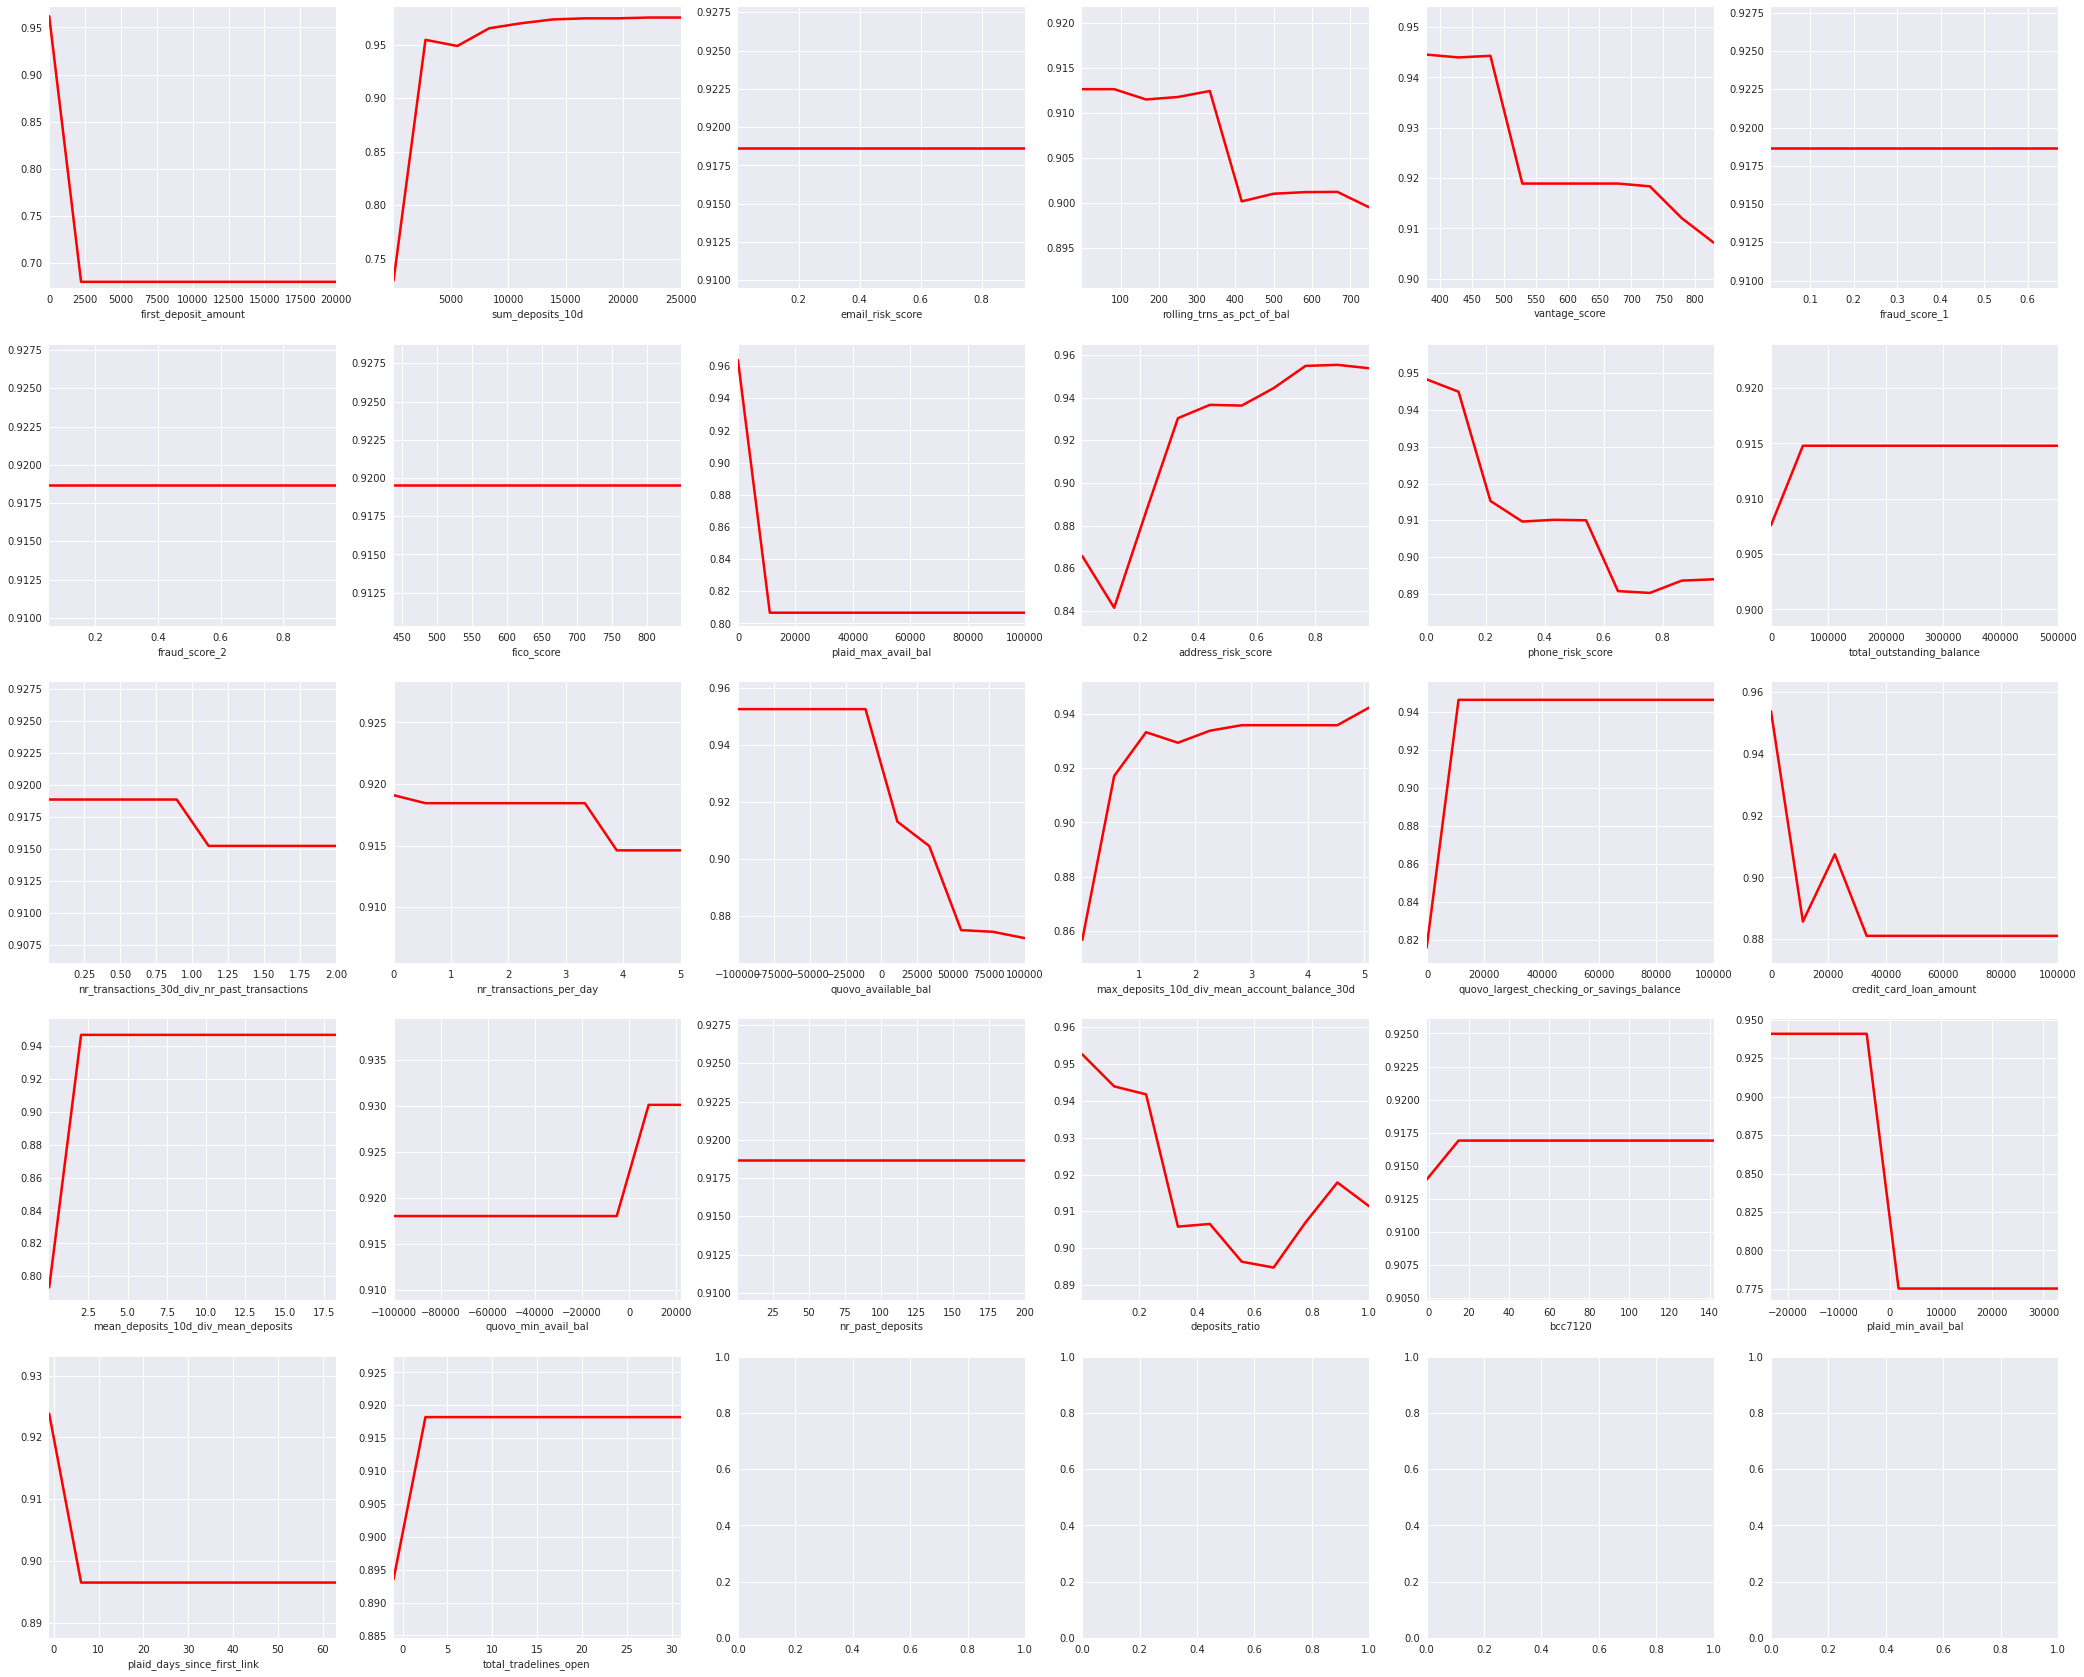

In [41]:
fig = get_pdp(modeling_df, features_by_imp, [model], ncols=6)
fig.savefig('../../artifacts/final/plots/pdp_ach_final.png')

### Reports
---

#### Model

In [42]:
# def scale_scores(predictions):
#     """
#     Convert probability to score.
#     """
#     try:
#         assert ((predictions >= 0) & (predictions <= 1)).all(), 'probability must be in range [0,1]'
#     except AssertionError:
#         raise

#     # Formula parameters
#     ALPHA = 631.9455383610933
#     BETA = 30.812519272450654

#     # Minimum and maximum values for validation
#     MINIMUM = 300
#     MAXIMUM = 850

#     score = np.minimum(np.maximum(np.log(predictions / (1 - predictions)) * BETA + ALPHA, MINIMUM), MAXIMUM)
   
#     return score

#### Prediction Segmentations

In [43]:
from rdsutils.plot import plot_pr_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix

# TODO: extend to other columns: fico, customer, etc, etc
def build_table1(modeling_df, percentiles, target_col_name, pred_col_name):
    """ cumulative """
    df = []
    for thresh, pctl in [(np.percentile(modeling_df[pred_col_name], pctl), pctl) for pctl in percentiles]:
        pred = modeling_df[pred_col_name] >= thresh
        rep = classification_report(y_true=modeling_df[target_col_name], y_pred=pred, output_dict=True)
        conf = confusion_matrix(y_true=modeling_df[target_col_name], y_pred=pred)
        tn, fp, fn, tp = conf.ravel()
        df.append([pctl, thresh, fp / (fp + tn) * 100, rep['True']['recall'] * 100,
                  sum(conf[:, 1]), conf[1][1], conf[1][0], conf[0][1], tn])
    return pd.DataFrame(df, columns=['Percentile', 'Threshold', 'False Positive Rate (%)', 
                                     'Fraud Capture Rate (%)', '#Above Threshold', '#Fraudulent Above Threshold', 
                                     '#Fraudulent Below Threshold', '#Good Above Threshold', '#True Negatives'])

In [44]:
# generate to google sheet/excel
to_csv = True
is_oos = True
pred_col = 'pred'
df = modeling_df if is_oos else test_df

In [45]:
tbl = build_table1(df, np.linspace(90, 99, 10)[::-1], target_col, pred_col).round(2)
if to_csv:
    print(tbl.to_csv(index=False))
else:
    print(tbl)

Percentile,Threshold,False Positive Rate (%),Fraud Capture Rate (%),#Above Threshold,#Fraudulent Above Threshold,#Fraudulent Below Threshold,#Good Above Threshold,#True Negatives
99.0,0.99,0.02,29.39,1126,1109,2665,17,108808
98.0,0.94,0.4,48.04,2252,1813,1961,439,108386
97.0,0.88,1.1,57.92,3378,2186,1588,1192,107633
96.0,0.81,1.9,64.55,4504,2436,1338,2068,106757
95.0,0.75,2.79,68.87,5630,2599,1175,3031,105794
94.0,0.68,3.7,72.36,6756,2731,1043,4025,104800
93.0,0.62,4.64,75.04,7882,2832,942,5050,103775
92.0,0.56,5.6,77.24,9008,2915,859,6093,102732
91.0,0.51,6.58,78.67,10134,2969,805,7165,101660
90.0,0.47,7.58,79.89,11260,3015,759,8245,100580



In [46]:
tbl = build_table1(df, np.linspace(0, 90, 10)[::-1], target_col, 'pred').round(2)
if to_csv:
    print(tbl.to_csv(index=False))
else:
    print(tbl)

Percentile,Threshold,False Positive Rate (%),Fraud Capture Rate (%),#Above Threshold,#Fraudulent Above Threshold,#Fraudulent Below Threshold,#Good Above Threshold,#True Negatives
90.0,0.47,7.58,79.89,11260,3015,759,8245,100580
80.0,0.22,17.66,87.47,22520,3301,473,19219,89606
70.0,0.14,27.87,91.52,33780,3454,320,30326,78499
60.0,0.1,38.13,93.85,45040,3542,232,41498,67327
50.0,0.07,48.42,95.52,56300,3605,169,52695,56130
40.0,0.05,58.73,96.66,67559,3648,126,63911,44914
30.0,0.04,69.03,97.93,78819,3696,78,75123,33702
20.0,0.03,79.34,98.89,90079,3732,42,86347,22478
10.0,0.02,89.67,99.58,101339,3758,16,97581,11244
0.0,0.0,100.0,100.0,112599,3774,0,108825,0



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


In [47]:
# output to xlsx
os.makedirs('../../artifacts/final/governance', exist_ok=True)

with pd.ExcelWriter('../../artifacts/final/governance/model_reports.xlsx') as writer:
    tbl_oos1 = build_table1(modeling_df, np.linspace(90, 99, 10)[::-1], target_col, 'pred').round(2)
    tbl_oos2 = build_table1(modeling_df, np.linspace(0, 90, 10)[::-1], target_col, 'pred').round(2)
    tbl_oos3 = build_table1(modeling_df, np.linspace(0, 99, 100)[::-1], target_col, 'pred').round(2)

    tbl_oot1 = build_table1(test_df, np.linspace(90, 99, 10)[::-1], target_col, 'pred').round(2)
    tbl_oot2 = build_table1(test_df, np.linspace(0, 90, 10)[::-1], target_col, 'pred').round(2)
    tbl_oot3 = build_table1(test_df, np.linspace(0, 99, 100)[::-1], target_col, 'pred').round(2)
    
    tbls = [(tbl_oos1, 'tbl_oos1'),
            (tbl_oos2, 'tbl_oos2'),
            (tbl_oos3, 'tbl_oos3'),
            (tbl_oot1, 'tbl_oot1'),
            (tbl_oot2, 'tbl_oot2'),
            (tbl_oot3, 'tbl_oot3')]
    
    for t, name in tbls:
        t.to_excel(writer, sheet_name=name)
        
with pd.ExcelWriter('../../artifacts/final/governance/customer_reports.xlsx') as writer:
    tbl_oos1 = build_table1(modeling_df, np.linspace(90, 99, 10)[::-1], target_col, 'customer_pred').round(2)
    tbl_oos2 = build_table1(modeling_df, np.linspace(0, 90, 10)[::-1], target_col, 'customer_pred').round(2)
    tbl_oos3 = build_table1(modeling_df, np.linspace(0, 99, 100)[::-1], target_col, 'customer_pred').round(2)

    tbl_oot1 = build_table1(test_df, np.linspace(90, 99, 10)[::-1], target_col, 'customer_pred').round(2)
    tbl_oot2 = build_table1(test_df, np.linspace(0, 90, 10)[::-1], target_col, 'customer_pred').round(2)
    tbl_oot3 = build_table1(test_df, np.linspace(0, 99, 100)[::-1], target_col, 'customer_pred').round(2)
    
    tbls = [(tbl_oos1, 'tbl_oos1'),
            (tbl_oos2, 'tbl_oos2'),
            (tbl_oos3, 'tbl_oos3'),
            (tbl_oot1, 'tbl_oot1'),
            (tbl_oot2, 'tbl_oot2'),
            (tbl_oot3, 'tbl_oot3')]
    
    for t, name in tbls:
        t.to_excel(writer, sheet_name=name)

ModuleNotFoundError: No module named 'openpyxl'

### Individual Features, if needed...
---

In [ ]:
# check out customer info-for-governance-v2